In [57]:
import os, re, json, requests
import PyPDF2
import urllib.request
from bs4 import BeautifulSoup
from scipy import stats

import prince
import numpy as np
import pandas as pd
import random
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import mca

import xgboost as xgb
from bayes_opt import BayesianOptimization

#os.chdir('/content/drive/MyDrive/Tübingen/Sem1/DLit/Project')

In [3]:
import maps

In [4]:
pd.set_option('display.max_columns', 500)
plt.style.use('ggplot')

In [5]:
DATA_DIR = 'data/internet'
!ls $DATA_DIR; tree $DATA_DIR/

2019 2021
zsh:1: command not found: tree


In [6]:
PERSONTYPE = 'PRPERTYP'
SEX = 'PESEX'
AGE = 'PRTAGE'
STATECODE = 'GESTFIPS'
SOCIALMEDIA = 'PESOCIAL'
TEXTING = 'PETEXTIM'
EMAIL = 'PEEMAIL'

# During the past year, (have you/has any member of your household) been affected by an
# online security breach, identity theft, or a similar crime?
CYBERCRIME='HEPSCYBA'


#what concerns (you/members of this household) the most when it comes to online privacy and security risks?
CONCERNS_MAP = {
    'HEPSCON1': 'Identity theft',
    'HEPSCON2': 'Credit card or banking fraud',
    'HEPSCON3': 'Data collection or tracking by online services',
    'HEPSCON4': 'Data collection or tracking by government',
    'HEPSCON5': 'Loss of control over personal data such as email or social network profiles',
    'HEPSCON6': 'Threats to personal safety, such as online harassment, stalking, or cyberbullying',
    'HEPSCON8': 'Other concerns'
}

# During the past year, have concerns about privacy or security STOPPED (you/anyone in this household)
# from doing any of these activities online
ACTIVITIES_MAP = {
    'HEPSPRE1': 'Conducting financial transactions such as banking, investing, or paying bills online?',
    'HEPSPRE2': 'Buying goods or services online?',
    'HEPSPRE3': 'Posting photos, status updates, or other information on social networks?',
    'HEPSPRE4': 'Expressing an opinion on a controversial or political issue on a blog or social network, or in a forum, email or any other venue?',
    'HEPSPRE5': 'Searching for information using a platform such as Google Search, Yahoo Search, Microsoft Bing, or another web search engine?'
}



In [7]:
year = '2021'
# variables = variables_all[year]
CSV_FILE_PATH = os.path.join(DATA_DIR, f"{year}/nov{year[2:]}pub.csv")

In [8]:
df21 = pd.read_csv(CSV_FILE_PATH)
# df21 = df21[(df21[PERSONTYPE] == 2) * (df21[SEX] != -1)]
df21 = df21[(df21[AGE] >= 10) * (df21[SEX] != -1)]
columns = df21.columns.to_list()
df21

,HRHHID,HRMONTH,HRYEAR4,HURESPLI,HUFINAL,FILLER,HETENURE,HEHOUSUT,HETELHHD,HETELAVL,HEPHONEO,HEFAMINC,HUTYPEA,HUTYPB,HUTYPC,HWHHWGT,HRINTSTA,HRNUMHOU,HRHTYPE,HRMIS,HUINTTYP,HUPRSCNT,HRLONGLK,HRHHID2,HWHHWTLN,HUBUS,HUBUSL1,HUBUSL2,HUBUSL3,HUBUSL4,GEREG,GEDIV,GESTFIPS,GTCBSA,GTCO,GTCBSAST,GTMETSTA,GTINDVPC,GTCBSASZ,GTCSA,PERRP,PRTAGE,PRTFAGE,PEMARITL,PESPOUSE,PESEX,PEAFEVER,PEAFNOW,PEEDUCA,PTDTRACE,PRDTHSP,PUCHINHH,PULINENO,PRFAMNUM,PRFAMREL,PRFAMTYP,PEHSPNON,PRMARSTA,PRPERTYP,PENATVTY,PEMNTVTY,PEFNTVTY,PRCITSHP,PRCITFLG,PRINUYER,PUSLFPRX,PEMLR,PUWK,PUBUS1,PUBUS2OT,PUBUSCK1,PUBUSCK2,PUBUSCK3,PUBUSCK4,PURETOT,PUDIS,PERET1,PUDIS1,PUDIS2,PUABSOT,PULAY,PEABSRSN,PEABSPDO,PEMJOT,PEMJNUM,PEHRUSL1,PEHRUSL2,PEHRFTPT,PEHRUSLT,PEHRWANT,PEHRRSN1,PEHRRSN2,PEHRRSN3,PUHROFF1,PUHROFF2,PUHROT1,PUHROT2,PEHRACT1,PEHRACT2,PEHRACTT,PEHRAVL,PUHRCK1,PUHRCK2,PUHRCK3,PUHRCK4,PUHRCK5,PUHRCK6,PUHRCK7,PUHRCK12,PULAYDT,PULAY6M,PELAYAVL,PULAYAVR,PELAYLK,PELAYDUR,PELAYFTO,PULAYCK1,PULAYCK2,PULAYCK3,PULK,PELKM1,PULKM2,PULKM3,PULKM4,PULKM5,PULKM6,PULKDK1,PULKDK2,PULKDK3,PULKDK4,PULKDK5,PULKDK6,PULKPS1,PULKPS2,PULKPS3,PULKPS4,PULKPS5,PULKPS6,PELKAVL,PULKAVR,PELKLL1O,PELKLL2O,PELKLWO,PELKDUR,PELKFTO,PEDWWNTO,PEDWRSN,PEDWLKO,PEDWWK,PEDW4WK,PEDWLKWK,PEDWAVL,PEDWAVR,PUDWCK1,PUDWCK2,PUDWCK3,PUDWCK4,PUDWCK5,PEJHWKO,PUJHDP1O,PEJHRSN,PEJHWANT,PUJHCK1,PUJHCK2,PRABSREA,PRCIVLF,PRDISC,PREMPHRS,PREMPNOT,PREXPLF,PRFTLF,PRHRUSL,PRJOBSEA,PRPTHRS,PRPTREA,PRUNEDUR,PRUNTYPE,PRWKSCH,PRWKSTAT,PRWNTJOB,PUJHCK3,PUJHCK4,PUJHCK5,PUIODP1,PUIODP2,PUIODP3,PEIO1COW,PUIO1MFG,PEIO2COW,PUIO2MFG,PUIOCK1,PUIOCK2,PUIOCK3,PRIOELG,PRAGNA,PRCOW1,PRCOW2,PRCOWPG,PRDTCOW1,PRDTCOW2,PRDTIND1,PRDTIND2,PRDTOCC1,PRDTOCC2,PREMP,PRMJIND1,PRMJIND2,PRMJOCC1,PRMJOCC2,PRMJOCGR,PRNAGPWS,PRNAGWS,PRSJMJ,PRERELG,PEERNUOT,PEERNPER,PEERNRT,PEERNHRY,PTERNH1C,PTERNH2,PTERNH1O,PTERNHLY,PTHR,PEERNHRO,PTERNWA,PTWK,PTERN,PTERN2,PTOT,PEERNWKP,PEERNLAB,PEERNCOV,PENLFJH,PENLFRET,PENLFACT,PUNLFCK1,PUNLFCK2,PESCHENR,PESCHFT,PESCHLVL,PRNLFSCH,PWFMWGT,PWLGWGT,PWORWGT,PWSSWGT,PWVETWGT,PRCHLD,PRNMCHLD,PXPDEMP1,PRWERNAL,...,PXERNPER,PXERNH1O,PXERNHRO,PXERN,PXPDEMP2,PXNMEMP2,PXERNWKP,PXERNRT,PXERNHRY,PXERNH2,PXERNLAB,PXERNCOV,PXNLFJH,PXNLFRET,PXNLFACT,PXSCHENR,PXSCHFT,PXSCHLVL,QSTNUM,OCCURNUM,PEDIPGED,PEHGCOMP,PECYC,PXDIPGED,PXHGCOMP,PXCYC,PWCMPWGT,PEIO1ICD,PTIO1OCD,PEIO2ICD,PTIO2OCD,PRIMIND1,PRIMIND2,PEAFWHN1,PEAFWHN2,PEAFWHN3,PEAFWHN4,PXAFEVER,PEPAR2,PEPAR1,PEPAR2TYP,PEPAR1TYP,PECOHAB,PXPAR2,PXPAR1,PXPAR2TYP,PXPAR1TYP,PXCOHAB,PEDISEAR,PEDISEYE,PEDISREM,PEDISPHY,PEDISDRS,PEDISOUT,PRDISFLG,PXDISEAR,PXDISEYE,PXDISREM,PXDISPHY,PXDISDRS,PXDISOUT,HXFAMINC,PRDASIAN,PEPDEMP1,PTNMEMP1,PEPDEMP2,PTNMEMP2,PECERT1,PECERT2,PECERT3,PXCERT1,PXCERT2,PXCERT3,HEDESKTP,PEDESKTP,HELAPTOP,PELAPTOP,HETABLET,PETABLET,HEMPHONE,PEMPHONE,HEWEARAB,PEWEARAB,HETVBOX,PETVBOX,HEDEVQUA,HEDEVSTA,HEINHOME,PEINHOME,HEINWORK,PEINWORK,HEINSCHL,PEINSCHL,HEINCAFE,PEINCAFE,HEINTRAV,PEINTRAV,HEINLICO,PEINLICO,HEINELHO,PEINELHO,HEINOTHR,PEINOTHR,HENETCHK,PENETCK2,HEMOBDAT,HEHMINT1,HEHMINT2,HEHOMTE1,HEHOMTE2,HEHOMTE3,HEHOMTE4,HEHNETQL,HEHNETST,PEEMAIL,PETEXTIM,PESOCIAL,PEGAMING,PECONFER,PEVIDEO,PEAUDIO,PEPUBLISH,PETELEWK,PEJOBSCH,PEEDTRAI,PEEGOVTS,PEUSESVC,PEESRVCS,PEECOMME,PEEGOODS,PEFINANC,PEVOICEA,PEHOMIOT,HEMEDREC,HEMEDDOC,HEMEDINF,HEMEDMON,HEPSPRE1,HEPSPRE2,HEPSPRE3,HEPSPRE4,HEPSPRE5,HEPSCON1,HEPSCON2,HEPSCON3,HEPSCON4,HEPSCON5,HEPSCON6,HEPSCON8,HEPSCYBA,HEEVRHOM,HENOHM1,HENOHM2,HENOHM3,HENOHM4,HENOHM5,HENOHM6,HENOHM7,HENOHM8,HENOHM9,HENOHM10,HEPRINOH,HELOPRCE,HETRADTV,HEPREVTV,HENOTV1,HENOTV2,HENOTV3,HENOTV4,HENOTV5,HENOTV6,HENOTV7,HENOTV8,HENOTV9,HENOTV10,HENOTV11,HENOTV12,PUELGFLG,HXDESKTP,HXLAPTOP,HXTABLET,HXMPHONE,HXWEARAB,HXTVBOX,HXDEVQUA,HXDEVSTA,HXINHOME,HXINWORK,HXINSCHL,HXINCAFE,HXINTRAV,HXINLICO,HXINELHO,HXINOTHR,HXHOMTE1,HXHOMTE2,HXHOMTE3,HXHOMTE4,HXMOBDAT,HXHNETQL,HXHNETST,HXPSPRE1,HXPSCON1,HXMEDREC,HXMEDDOC,HXMEDINF,HXMEDMON,HXPSCYBA,HXNOHM1,HXEVRHOM,HXPRINOH,HXLOPRCE,HXNOTV1,HXTRADTV,HXPREVTV,PXDESKTP,PXLAPTOP,PXTABLET,PXMPHONE,PXWEARAB,PXTVBOX,PXINHOME,PX

In [9]:
df21[AGE].unique()

array([24, 28, 45, 30, 22, 42, 70, 62, 54, 39, 19, 33, 14, 73, 76, 61, 67,
       65, 59, 56, 58, 36, 40, 71, 68, 21, 72, 60, 51, 52, 48, 75, 74, 16,
       32, 29, 35, 53, 38, 43, 78, 20, 23, 26, 41, 27, 57, 85, 15, 31, 10,
       55, 46, 47, 49, 34, 66, 25, 17, 12, 79, 80, 13, 63, 77, 69, 44, 50,
       64, 11, 18, 37])

In [10]:
concerns = [f'HEPSCON{i}' for i in range(1, 9) if i!=7]
activities = list(ACTIVITIES_MAP.keys())
activities

['HEPSPRE1', 'HEPSPRE2', 'HEPSPRE3', 'HEPSPRE4', 'HEPSPRE5']

In [11]:
df21.columns.get_loc('PXPDEMP1') #Starting of ALLOCATION FLAGS

248

In [12]:
df21.columns.get_loc('PXCERT3') #Page 110 of documentation

390

In [13]:
df21.iloc[:,391]

0         2
1         2
5         2
6         2
7         2
         ..
127369    2
127370    2
127372    2
127373    2
127374    2
Name: HEDESKTP, Length: 90941, dtype: int64

In [14]:
#Drop all columns related to ALLOCATION FLAGS

df21 = df21.drop(df21.iloc[:, 248:391],axis = 1)

In [15]:
df21.shape

(90941, 425)

# try classification

In [16]:
def has_any_concern(row):
    for column in [f'{item} == 1' for item in [f'HEPSCON{i}' for i in [1,2,3,4,5,6,8]]]:
            if (row['HEPSCON1'] == 1) or (row['HEPSCON2'] == 1) or (row['HEPSCON3'] == 1)\
                    or (row['HEPSCON4'] == 1) or (row['HEPSCON5'] == 1) or (row['HEPSCON6'] == 1)\
                    or (row['HEPSCON8'] == 1):
                return 1
            else:
                return 0

def hesitates_to_do_activity(row):
    for column in [f'{item} == 1' for item in [f'HEPSPRE{i}' for i in [1,2,3,4,5]]]:
            if (row['HEPSPRE1'] == 1) or (row['HEPSPRE2'] == 1) or (row['HEPSPRE3'] == 1)\
                    or (row['HEPSPRE4'] == 1) or (row['HEPSPRE5'] == 1):
                return 1
            else:
                return 0

df21['HAS_SOME_CONCERN'] = df21.apply(has_any_concern, axis=1)
df21['HESITATES'] = df21.apply(hesitates_to_do_activity, axis=1)

In [17]:
df21['HAS_SOME_CONCERN'].value_counts()

HAS_SOME_CONCERN
1    55588
0    35353
Name: count, dtype: int64

In [18]:
df21['HESITATES'].value_counts()

HESITATES
0    66315
1    24626
Name: count, dtype: int64

In [19]:
PERSONTYPE = 'PRPERTYP'
SEX = 'PESEX'
AGE = 'PRTAGE'
STATECODE = 'GESTFIPS'
SOCIALMEDIA = 'PESOCIAL'
TEXTING = 'PETEXTIM'
EMAIL = 'PEEMAIL'





# During the past year, (have you/has any member of your household) been affected by an
# online security breach, identity theft, or a similar crime?
CYBERCRIME='HEPSCYBA'


In [20]:
df21['PRUNTYPE'].value_counts()

PRUNTYPE
-1    89117
 5      557
 2      510
 4      246
 1      225
 3      169
 6      117
Name: count, dtype: int64

In [21]:
df21['HESITATES']

0         0
1         0
5         0
6         1
7         1
         ..
127369    1
127370    1
127372    0
127373    0
127374    0
Name: HESITATES, Length: 90941, dtype: int64

In [22]:
df21 = df21.assign(EDUC_LEVEL=lambda x: pd.Categorical(x['PEEDUCA'].map(maps.educ)))

In [23]:
maps.EducDTMap.keys()

dict_keys([31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46])

In [24]:
filter_variables = [
    PERSONTYPE, SEX, AGE, STATECODE, SOCIALMEDIA, TEXTING, EMAIL, CYBERCRIME,
    'HAS_SOME_CONCERN', 'HESITATES',
    'state',



#     *list(CONCERNS_MAP.keys()),
#     *list(ACTIVITIES_MAP.keys()),

]

In [25]:
df21['EDUC_LEVEL']

0         NaN
1         NaN
5         NaN
6         NaN
7         NaN
         ... 
127369    NaN
127370    NaN
127372    NaN
127373    NaN
127374    NaN
Name: EDUC_LEVEL, Length: 90941, dtype: category
Categories (0, object): []

In [26]:
filter_variables

['PRPERTYP',
 'PESEX',
 'PRTAGE',
 'GESTFIPS',
 'PESOCIAL',
 'PETEXTIM',
 'PEEMAIL',
 'HEPSCYBA',
 'HAS_SOME_CONCERN',
 'HESITATES',
 'state']

In [27]:
# df21['state']
maps.ind

{'Construction and mining': [1, 2, 3],
 'Finance and business services': [7, 8, 9, 12],
 'Manufacturing': [4],
 'Trade, transportation, and utilities': [5, 6],
 'Education and health': [10],
 'Leisure and hospitality': [11],
 'Public administration': [13],
 'Armed forces': [14]}

In [28]:
pd.Categorical(df21['GESTFIPS'].map(maps.StatesMap))

['AL', 'AL', 'AL', 'AL', 'AL', ..., 'WY', 'WY', 'WY', 'WY', 'WY']
Length: 90941
Categories (51, object): ['AK', 'AL', 'AR', 'AZ', ..., 'WA', 'WI', 'WV', 'WY']

In [29]:
# New variables to add
state = lambda x: pd.Categorical(x['GESTFIPS'].map(maps.StatesMap))
region = lambda x: pd.Categorical(x['STATE'].map(maps.RegionsMap))
educdt = lambda x: pd.Categorical(x['PEEDUCA'].map(maps.EducDTMap))
educ = lambda x: pd.Categorical(x['PEEDUCA'].map(maps.educ))
schenr = lambda x: pd.Categorical(
    np.where(x['PESCHENR'] == 1, 1,
    np.where(x['PESCHENR'] == 2, 0, None)))
married = lambda x: pd.Categorical(
    np.where(x['PRMARSTA'].isin([1, 2, 3]), 1, 0))
# wbhao = lambda x: pd.Categorical(
#     np.where(x['PRDTHSP'].isin(maps.hispanic), 'Hispanic',
#              x['PRDTRACE'].map(maps.race)))
wbao = lambda x: pd.Categorical(x['PRDTRACE'].map(maps.race))

veteran = lambda x: pd.Categorical(
    np.where(x['PEAFEVER'] == 1, 1,
    np.where(x['PEAFEVER'] == 2, 0, None)))
forborn = lambda x: pd.Categorical(
    np.where(x['PRCITSHP'].isin([4, 5]), 1,
    np.where(x['PRCITSHP'].isin([1, 2, 3]), 0, None)))

citizen = lambda x: pd.Categorical(
    np.where(x['PRCITSHP'].isin([1, 2, 3, 4]), 1,
    np.where(x['PRCITSHP'].isin([5]), 0, None)))

indgrp =  lambda x: pd.Categorical(x['PRMJIND1'].map(maps.ind))

manager = lambda x: np.where(x.PRDTOCC1 == 1, 1,
                    np.where(x.PRDTOCC1 > 0, 0, None))

mjh = lambda x: pd.Categorical(
    np.where(x['PRSJMJ']==2, 1, np.where(x['PRSJMJ']==1, 0, None)))

numjobs = lambda x: np.where(x.PEMJNUM > 1, x.PEMJNUM,
    np.where((x.MJH == 0) & (x.LFS == "Employed"), 1, 0))

unemptype = lambda x: pd.Categorical(
    np.where(x['PRUNTYPE'].isin([1, 2, 3]), 'Job Loser',
    np.where(x['PRUNTYPE'] == 4, 'Job Leaver',
    np.where(x['PRUNTYPE'] == 5, 'Re-entrant',
    np.where(x['PRUNTYPE'] == 6, 'New Entrant', None)))))

layoff = lambda x: pd.Categorical(
    np.where(x['PEMLR'] == 3, 'Layoff',
    np.where(x['PEMLR'] == 4, 'Looking', None)))

lfs = lambda x: pd.Categorical(
        np.where(x['PEMLR'].isin([1, 2]), 'Employed',
        np.where(x['PEMLR'].isin([3, 4]), 'Unemployed',
        np.where(x['PEMLR'].isin([5, 6, 7]), 'NILF', np.nan))))


school = lambda x: pd.Categorical(
        np.where(x.PESCHLVL == 1, 'High School',
        np.where((x.PESCHLVL == 2) & (x.PESCHFT == 1), 'Full-time College',
        np.where((x.PESCHLVL == 2) & (x.PESCHFT == 2), 'Part-time College',
        np.where(x.SCHENR == 0, 'Not Enrolled', None)))))

uslft = lambda x: pd.Categorical(
        np.where((x['PEHRFTPT'] == 1) | (x['PEHRUSL1'] >= 35), 1,
        np.where(x['PEHRFTPT'] == 2, 0,
        np.where(x['PEHRFTPT'] == 3, -4, None))))

In [31]:
df21 = (df21.assign(STATE = state(df21),
                    EDUCDT = educdt(df21),
#                     EDUC = educ,
                    SCHENR = schenr(df21),
#                     RETIRED = retired,
                    MARRIED = married(df21),
#                     WBHAO = wbhao,
#                     WBAO = wbao,
#                     HISPANIC = hispanic,
                    VETERAN = veteran(df21),
                    FORBORN = forborn(df21),
                    CITIZEN = citizen(df21),
                    UNEMPTYPE = unemptype(df21),
#                     JLTYPE = jltype,
                    LAYOFF = layoff(df21),
#                     PTECON = ptecon,
                    USLFT = uslft(df21),
#                     WORKFT = workft,
#                     FTLF = ftlf,
#                     SAMEEMP = sameemp,
                   )
       )



df21 = df21.assign(REGION = region(df21), SCHOOL = school(df21))


In [32]:
df21['PESCHLVL'].value_counts()

PESCHLVL
-1    83489
 2     4542
 1     2910
Name: count, dtype: int64

In [33]:
df21['SCHOOL'].value_counts()

SCHOOL
Not Enrolled         40906
Full-time College     3450
High School           2910
Part-time College     1092
Name: count, dtype: int64

In [34]:
df21['SCHOOL'].unique()

['Not Enrolled', 'Full-time College', NaN, 'High School', 'Part-time College']
Categories (4, object): ['Full-time College', 'High School', 'Not Enrolled', 'Part-time College']

In [35]:
import xgboost as xgb

In [36]:
df_train = df21[['STATE', 'REGION', 'EDUCDT', 'SCHENR', 'SCHOOL', 'MARRIED', 'VETERAN', 'FORBORN', 'CITIZEN', 'UNEMPTYPE', 'LAYOFF', 'USLFT']].copy()

df_train['STATE'] = state(df21)
df_train['REGION'] = region(df21)
df_train['EDUCDT'] = educdt(df21)
df_train['SCHENR'] = schenr(df21)
df_train['SCHOOL'] = school(df21)
df_train['MARRIED'] = married(df21)
df_train['VETERAN'] = veteran(df21)
df_train['FORBORN'] = forborn(df21)
df_train['CITIZEN'] = citizen(df21)
df_train['UNEMPTYPE'] = unemptype(df21)
df_train['LAYOFF'] = layoff(df21)
df_train['USLFT'] = uslft(df21)

In [37]:
df_train['EDUCDT']

0                         11th grade
1         Some college but no degree
5                   HS graduate, GED
6                  Bachelor's degree
7                  Bachelor's degree
                     ...            
127369    Some college but no degree
127370              HS graduate, GED
127372                    11th grade
127373              HS graduate, GED
127374                    10th grade
Name: EDUCDT, Length: 90941, dtype: category
Categories (16, object): ['10th grade', '11th grade', '12th grade-no diploma', '1st-4th grade', ..., 'Less than 1st grade', 'Master's degree', 'Professional school', 'Some college but no degree']

In [38]:
# column names having even one null value:
any_null = list(df_train.isnull().any().index)
print(any_null)

['STATE', 'REGION', 'EDUCDT', 'SCHENR', 'SCHOOL', 'MARRIED', 'VETERAN', 'FORBORN', 'CITIZEN', 'UNEMPTYPE', 'LAYOFF', 'USLFT']


In [39]:
# check datatypes of df_train

# loop through all columns in df21, and add all non numerical and non categorical columns to a list
non_numerical_cols = []
for col in df21.columns:
    if df21[col].dtype == object:
        non_numerical_cols.append(col)

# add columns that contain all NaN values to the list
for col in df21.columns:
    if df21[col].isnull().all():
        non_numerical_cols.append(col)

non_numerical_cols += ["HAS_SOME_CONCERN", "HESITATES"] + ["HEPSCON" + str(i) for i in range(1, 9)] + ["HEPSPRE" + str(i) for i in range(1, 6)]

# drop all non numerical and non categorical columns from df21
df_train1 = df21.drop(columns = non_numerical_cols, errors="ignore")



In [40]:
df_train1

,HRHHID,HRMONTH,HRYEAR4,HURESPLI,HUFINAL,HETENURE,HEHOUSUT,HETELHHD,HETELAVL,HEPHONEO,HEFAMINC,HUTYPEA,HUTYPB,HUTYPC,HWHHWGT,HRINTSTA,HRNUMHOU,HRHTYPE,HRMIS,HUINTTYP,HUPRSCNT,HRLONGLK,HRHHID2,HWHHWTLN,HUBUS,HUBUSL1,HUBUSL2,HUBUSL3,HUBUSL4,GEREG,GEDIV,GESTFIPS,GTCBSA,GTCO,GTCBSAST,GTMETSTA,GTINDVPC,GTCBSASZ,GTCSA,PERRP,PRTAGE,PRTFAGE,PEMARITL,PESPOUSE,PESEX,PEAFEVER,PEAFNOW,PEEDUCA,PTDTRACE,PRDTHSP,PUCHINHH,PULINENO,PRFAMNUM,PRFAMREL,PRFAMTYP,PEHSPNON,PRMARSTA,PRPERTYP,PENATVTY,PEMNTVTY,PEFNTVTY,PRCITSHP,PRCITFLG,PRINUYER,PUSLFPRX,PEMLR,PUWK,PUBUS1,PUBUS2OT,PUBUSCK1,PUBUSCK2,PUBUSCK3,PUBUSCK4,PURETOT,PUDIS,PERET1,PUDIS1,PUDIS2,PUABSOT,PULAY,PEABSRSN,PEABSPDO,PEMJOT,PEMJNUM,PEHRUSL1,PEHRUSL2,PEHRFTPT,PEHRUSLT,PEHRWANT,PEHRRSN1,PEHRRSN2,PEHRRSN3,PUHROFF1,PUHROFF2,PUHROT1,PUHROT2,PEHRACT1,PEHRACT2,PEHRACTT,PEHRAVL,PUHRCK1,PUHRCK2,PUHRCK3,PUHRCK4,PUHRCK5,PUHRCK6,PUHRCK7,PUHRCK12,PULAYDT,PULAY6M,PELAYAVL,PULAYAVR,PELAYLK,PELAYDUR,PELAYFTO,PULAYCK1,PULAYCK2,PULAYCK3,PULK,PELKM1,PULKM2,PULKM3,PULKM4,PULKM5,PULKM6,PULKDK1,PULKDK2,PULKDK3,PULKDK4,PULKDK5,PULKDK6,PULKPS1,PULKPS2,PULKPS3,PULKPS4,PULKPS5,PULKPS6,PELKAVL,PULKAVR,PELKLL1O,PELKLL2O,PELKLWO,PELKDUR,PELKFTO,PEDWWNTO,PEDWRSN,PEDWLKO,PEDWWK,PEDW4WK,PEDWLKWK,PEDWAVL,PEDWAVR,PUDWCK1,PUDWCK2,PUDWCK3,PUDWCK4,PUDWCK5,PEJHWKO,PUJHDP1O,PEJHRSN,PEJHWANT,PUJHCK1,PUJHCK2,PRABSREA,PRCIVLF,PRDISC,PREMPHRS,PREMPNOT,PREXPLF,PRFTLF,PRHRUSL,PRJOBSEA,PRPTHRS,PRPTREA,PRUNEDUR,PRUNTYPE,PRWKSCH,PRWKSTAT,PRWNTJOB,PUJHCK3,PUJHCK4,PUJHCK5,PUIODP1,PUIODP2,PUIODP3,PEIO1COW,PUIO1MFG,PEIO2COW,PUIO2MFG,PUIOCK1,PUIOCK2,PUIOCK3,PRIOELG,PRAGNA,PRCOW1,PRCOW2,PRCOWPG,PRDTCOW1,PRDTCOW2,PRDTIND1,PRDTIND2,PRDTOCC1,PRDTOCC2,PREMP,PRMJIND1,PRMJIND2,PRMJOCC1,PRMJOCC2,PRMJOCGR,PRNAGPWS,PRNAGWS,PRSJMJ,PRERELG,PEERNUOT,PEERNPER,PEERNRT,PEERNHRY,PTERNH1C,PTERNH2,PTERNH1O,PTERNHLY,PTHR,PEERNHRO,PTERNWA,PTWK,PTERN,PTERN2,PTOT,PEERNWKP,PEERNLAB,PEERNCOV,PENLFJH,PENLFRET,PENLFACT,PUNLFCK1,PUNLFCK2,PESCHENR,PESCHFT,PESCHLVL,PRNLFSCH,PWFMWGT,PWLGWGT,PWORWGT,PWSSWGT,PWVETWGT,PRCHLD,PRNMCHLD,HEDESKTP,PEDESKTP,HELAPTOP,PELAPTOP,HETABLET,PETABLET,HEMPHONE,PEMPHONE,HEWEARAB,PEWEARAB,HETVBOX,PETVBOX,HEDEVQUA,HEDEVSTA,HEINHOME,PEINHOME,HEINWORK,PEINWORK,HEINSCHL,PEINSCHL,HEINCAFE,PEINCAFE,HEINTRAV,PEINTRAV,HEINLICO,PEINLICO,HEINELHO,PEINELHO,HEINOTHR,PEINOTHR,HENETCHK,PENETCK2,HEMOBDAT,HEHMINT1,HEHMINT2,HEHOMTE1,HEHOMTE2,HEHOMTE3,HEHOMTE4,HEHNETQL,HEHNETST,PEEMAIL,PETEXTIM,PESOCIAL,PEGAMING,PECONFER,PEVIDEO,PEAUDIO,PEPUBLISH,PETELEWK,PEJOBSCH,PEEDTRAI,PEEGOVTS,PEUSESVC,PEESRVCS,PEECOMME,PEEGOODS,PEFINANC,PEVOICEA,PEHOMIOT,HEMEDREC,HEMEDDOC,HEMEDINF,HEMEDMON,HEPSCYBA,HEEVRHOM,HENOHM1,HENOHM2,HENOHM3,HENOHM4,HENOHM5,HENOHM6,HENOHM7,HENOHM8,HENOHM9,HENOHM10,HEPRINOH,HELOPRCE,HETRADTV,HEPREVTV,HENOTV1,HENOTV2,HENOTV3,HENOTV4,HENOTV5,HENOTV6,HENOTV7,HENOTV8,HENOTV9,HENOTV10,HENOTV11,HENOTV12,PUELGFLG,HXDESKTP,HXLAPTOP,HXTABLET,HXMPHONE,HXWEARAB,HXTVBOX,HXDEVQUA,HXDEVSTA,HXINHOME,HXINWORK,HXINSCHL,HXINCAFE,HXINTRAV,HXINLICO,HXINELHO,HXINOTHR,HXHOMTE1,HXHOMTE2,HXHOMTE3,HXHOMTE4,HXMOBDAT,HXHNETQL,HXHNETST,HXPSPRE1,HXPSCON1,HXMEDREC,HXMEDDOC,HXMEDINF,HXMEDMON,HXPSCYBA,HXNOHM1,HXEVRHOM,HXPRINOH,HXLOPRCE,HXNOTV1,HXTRADTV,HXPREVTV,PXDESKTP,PXLAPTOP,PXTABLET,PXMPHONE,PXWEARAB,PXTVBOX,PXINHOME,PXINWORK,PXINSCHL,PXINCAFE,PXINTRAV,PXINLICO,PXINELHO,PXINOTHR,PXNETCK2,PXEMAIL,PXTEXTIM,PXSOCIAL,PXGAMING,PXCONFER,PXVIDEO,PXAUDIO,PXPUBLISH,PXTELEWK,PXJOBSCH,PXEDTRAI,PXEGOVTS,PXUSESVC,PXESRVCS,PXECOMME,PXEGOODS,PXFINANC,PXVOICEA,PXHOMIOT,PWPRMWGT,STATE,EDUCDT,SCHENR,MARRIED,VETERAN,FORBORN,CITIZEN,UNEMPTYPE,LAYOFF,USLFT,REGION,SCHOOL
0,610905110108708,11,2021,1,201,1,1,1,-1,1,10,-1,-1,-1,31783716,1,5,4,5,1,1,3,12011,1,2,-1,-1,-1,-1,3,6,1,33860,0,2,1,0,3,0,40,24,0,6,-1,2,2,2,37,1,-1,9,1,1,1,1,2,7,2,57,57,57,1,0,0,1,7,2,-1,-1,2,-1,2,-1,-1,-1,-1,-1,-1,2,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,2,-1,-1,-1,-1,-1

In [41]:
print("HAS_SOME_CONCERN" in df_train1.columns)

False


In [42]:
non_numerical_cols

['FILLER',
 'EDUC_LEVEL',
 'HAS_SOME_CONCERN',
 'HESITATES',
 'HEPSCON1',
 'HEPSCON2',
 'HEPSCON3',
 'HEPSCON4',
 'HEPSCON5',
 'HEPSCON6',
 'HEPSCON7',
 'HEPSCON8',
 'HEPSPRE1',
 'HEPSPRE2',
 'HEPSPRE3',
 'HEPSPRE4',
 'HEPSPRE5']

In [43]:
df_train1.isnull().any()

HRHHID       False
HRMONTH      False
HRYEAR4      False
HURESPLI     False
HUFINAL      False
             ...  
UNEMPTYPE     True
LAYOFF        True
USLFT         True
REGION       False
SCHOOL        True
Length: 424, dtype: bool

In [44]:
# common (any)null columns in df_train and df_train1:
intersection_result = set(any_null).intersection(list(df_train1.isnull().any().index))
print(intersection_result)

{'CITIZEN', 'SCHENR', 'SCHOOL', 'USLFT', 'MARRIED', 'REGION', 'FORBORN', 'VETERAN', 'UNEMPTYPE', 'STATE', 'LAYOFF', 'EDUCDT'}


In [45]:
df_train1[any_null]

,STATE,REGION,EDUCDT,SCHENR,SCHOOL,MARRIED,VETERAN,FORBORN,CITIZEN,UNEMPTYPE,LAYOFF,USLFT
0,AL,South,11th grade,0,Not Enrolled,0,0,0,1,NaN,NaN,NaN
1,AL,South,Some college but no degree,0,Not Enrolled,0,0,0,1,NaN,NaN,1
5,AL,South,"HS graduate, GED",0,Not Enrolled,0,0,0,1,NaN,NaN,1
6,AL,South,Bachelor's degree,0,Not Enrolled,1,0,0,1,NaN,NaN,NaN
7,AL,South,Bachelor's degree,0,Not Enrolled,1,0,0,1,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...
127369,WY,West,Some college but no degree,NaN,NaN,1,0,0,1,NaN,NaN,1
127370,WY,West,"HS graduate, GED",NaN,NaN,1,0,0,1,NaN,NaN,1
127372,WY,West,11th grade,NaN,NaN,1,0,0,1,NaN,NaN,1
127373,WY,West,"HS graduate, GED",NaN,NaN,1,0,0,1,NaN,NaN,1


In [46]:
(df_train1.isnull().sum(axis=1) != 0).sum()

90941

In [47]:
df_train1.iloc[0].isnull().sum()

3

In [48]:
random.seed(time.time())

In [49]:
def XGBoost_training_loop(objective_col) :
    
    random.seed(time.time())
    train_accuracy = np.array([])
    test_accuracy = np.array([])
    trained_models = []
    
    
    
    for i in range(1):
        
    
    
        X_train, X_test, y_train, y_test = train_test_split(df_train1, df21[objective_col], test_size=0.2, random_state=random.randint(1,400))

        xgtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
        xgtest = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)

        def xgb_evaluate(max_depth, gamma, colsample_bytree):
            """
            Hyperparm seach for binary classification
            """
            params = {'eval_metric': 'error',
                      'max_depth': int(max_depth),
                      'subsample': 0.8,
                      'eta': 0.1,
                      'gamma': gamma,
                      'colsample_bytree': colsample_bytree,
                      'tree_method': 'hist',
                      'predictor': 'gpu_predictor',
                      'verbosity': 0}
            # Used around 1000 boosting rounds in the full model
            cv_result = xgb.cv(params, xgtrain, num_boost_round=100, nfold=3)

            return -cv_result['test-error-mean'].iloc[-1]

        xgb_bo = BayesianOptimization(xgb_evaluate, {'max_depth': (7, 12),
                                                     'gamma': (0, 1),
                                                     'colsample_bytree': (0.5, 0.9)},
                                     allow_duplicate_points=True)
        
        xgb_bo.maximize(init_points=5, n_iter=10, )

        sorted_res = sorted(xgb_bo.res,key = lambda x: x['target'])
        params = sorted_res[-1]
        params['params']['max_depth'] = int(params['params']['max_depth'])


        #Now train on the split



        model = xgb.train(params, xgtrain, num_boost_round=1000)

        # Evaluate model on training set
        y_pred_train = model.predict(xgtrain)
        y_pred_train = np.where(y_pred_train > 0.5, 1, 0)

        train_accuracy = np.append(train_accuracy, (accuracy_score(y_train, y_pred_train)))



        # Evaluate model on test set
        y_pred_test = model.predict(xgtest)
        y_pred_test = np.where(y_pred_test > 0.5, 1, 0)

        test_accuracy = np.append(test_accuracy, (accuracy_score(y_test, y_pred_test)))
        
        trained_models.append(model)
    
    print("Mean train accuracy:", train_accuracy.mean())
    print("Mean test accuracy:", test_accuracy.mean())
    
    return train_accuracy, test_accuracy, trained_models
    
    
    


In [50]:
train_accuracy, test_accuracy, models = XGBoost_training_loop(objective_col='HESITATES')

|   iter    |  target   | colsam... |   gamma   | max_depth |
-------------------------------------------------------------
| 1         | -0.2169   | 0.5849    | 0.6531    | 11.81     |
| 2         | -0.2301   | 0.8748    | 0.8304    | 8.941     |
| 3         | -0.2075   | 0.6655    | 0.3043    | 10.21     |
| 4         | -0.1941   | 0.6733    | 0.1461    | 11.39     |
| 5         | -0.2065   | 0.7185    | 0.3709    | 10.62     |
| 6         | -0.1986   | 0.5       | 0.0       | 11.1      |
| 7         | -0.1946   | 0.6425    | 0.1612    | 11.37     |
| 8         | -0.2371   | 0.5       | 0.0       | 7.0       |
| 9         | -0.1943   | 0.5944    | 0.005178  | 11.95     |
| 10        | -0.1785   | 0.9       | 0.0       | 12.0      |
| 11        | -0.188    | 0.9       | 0.0       | 11.77     |
| 12        | -0.238    | 0.9       | 1.0       | 7.517     |
| 13        | -0.2298   | 0.5113    | 0.9993    | 10.18     |
| 14        | -0.1909   | 0.9       | 0.2404    | 12.0      |
| 15    

/Users/gauravniranjan/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/gauravniranjan/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/gauravniranjan/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/gauravniranjan/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.Spa

In [59]:
model = models[0]

In [127]:
#Data split
X_train, X_test, y_train, y_test = train_test_split(df_train1, df21['HESITATES'], test_size=0.2, random_state=42)


In [126]:


# reference: https://www.kaggle.com/code/tilii7/bayesian-optimization-of-xgboost-parameters

xgtrain = xgb.DMatrix(df_train1, label=df21['HESITATES'], enable_categorical=True)

def xgb_evaluate(max_depth, gamma, colsample_bytree):
    """
    Hyperparm seach for binary classification
    """
    params = {'eval_metric': 'error',
              'max_depth': int(max_depth),
              'subsample': 0.8,
              'eta': 0.1,
              'gamma': gamma,
              'colsample_bytree': colsample_bytree,
              'tree_method': 'hist',
              'predictor': 'gpu_predictor',
              'verbosity': 0}
    # Used around 1000 boosting rounds in the full model
    cv_result = xgb.cv(params, xgtrain, num_boost_round=100, nfold=3)

    return -cv_result['test-error-mean'].iloc[-1]

xgb_bo = BayesianOptimization(xgb_evaluate, {'max_depth': (7, 12),
                                             'gamma': (0, 1),
                                             'colsample_bytree': (0.5, 0.9)})
xgb_bo.maximize(init_points=5, n_iter=10, )

|   iter    |  target   | colsam... |   gamma   | max_depth |
-------------------------------------------------------------
| 1         | -0.1772   | 0.6174    | 0.1129    | 11.89     |
| 2         | -0.2189   | 0.6603    | 0.6155    | 8.92      |
| 3         | -0.2259   | 0.825     | 0.1571    | 7.657     |
| 4         | -0.1954   | 0.6958    | 0.5126    | 10.31     |
| 5         | -0.198    | 0.5395    | 0.4113    | 10.83     |
| 6         | -0.201    | 0.9       | 1.0       | 12.0      |
| 7         | -0.1561   | 0.9       | 0.0       | 12.0      |
| 8         | -0.1683   | 0.9       | 0.0       | 11.57     |
| 9         | -0.2349   | 0.5       | 1.0       | 7.0       |
| 10        | -0.1631   | 0.9       | 0.178     | 12.0      |
| 11        | -0.1683   | 0.9       | 0.0       | 11.95     |
| 12        | -0.1676   | 0.8629    | 0.01519   | 11.95     |
| 13        | -0.1683   | 0.9       | 0.0       | 11.28     |
| 14        | -0.2176   | 0.7427    | 0.9616    | 9.227     |
| 15    

In [114]:
sorted_res = sorted(xgb_bo.res,key = lambda x: x['target'])
params = sorted_res[-1]
params['params']['max_depth'] = int(params['params']['max_depth'])


#Now train on the split



model = xgb.train(params, xgtrain, num_boost_round=1000)



<Axes: >

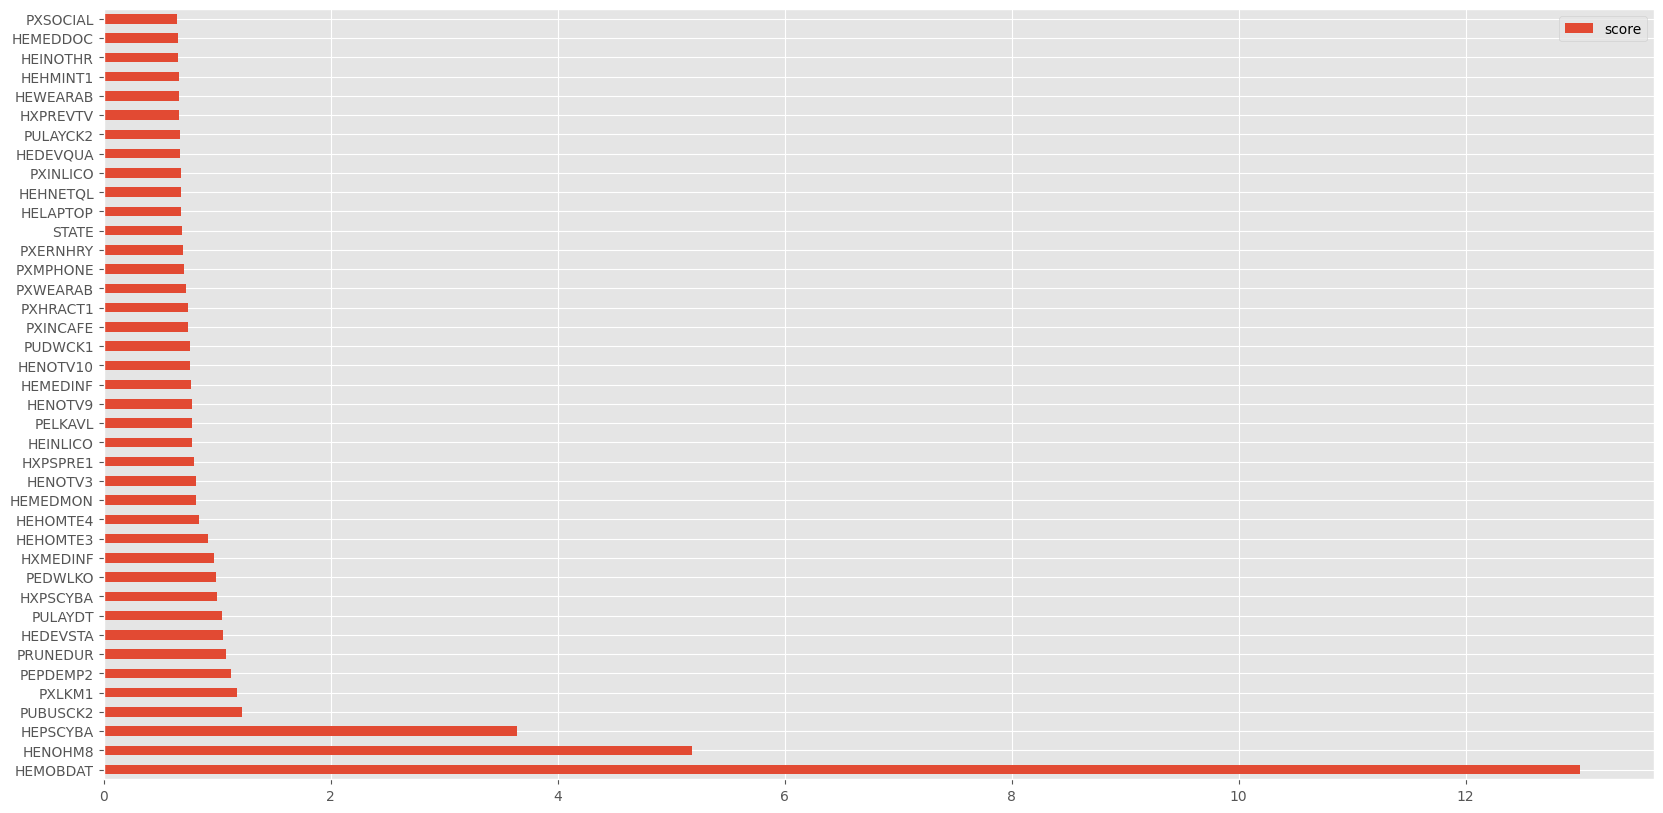

In [116]:
feature_important = model.get_score(importance_type='gain')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(40, columns="score").plot(kind='barh', figsize = (20,10)) ## plot top 40 features

<Axes: xlabel='X'>

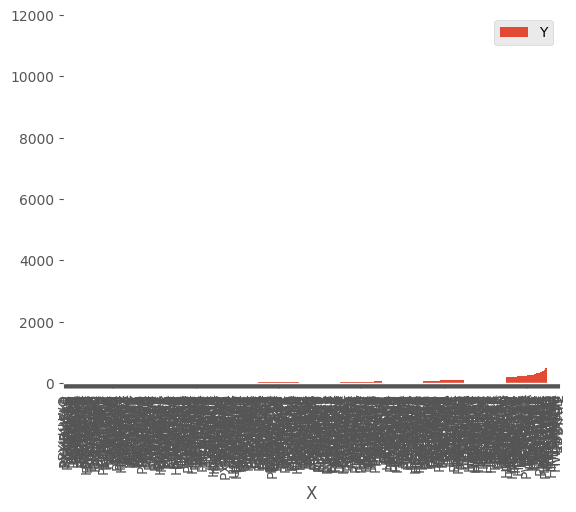

In [116]:
#Feature Importance
fscores = pd.DataFrame({'X': list(model.get_fscore().keys()), 'Y': list(model.get_fscore().values())})
fscores.sort_values(by='Y').plot.bar(x='X')

In [117]:
# Evaluate model on training set
y_pred_train = model.predict(xgtrain)
y_pred_train = np.where(y_pred_train > 0.5, 1, 0)
from sklearn.metrics import accuracy_score
accuracy_score(y_train, y_pred_train)

/Users/gauravniranjan/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/Users/gauravniranjan/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/Users/gauravniranjan/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/Users/gauravniranjan/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/Users/gauravniranjan/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605

0.9987354299538157

In [1]:
# Evaluate model on test set
xgtest = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)
y_pred_test = model.predict(xgtest)
y_pred_test = np.where(y_pred_test > 0.5, 1, 0)
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred_test)

NameError: name 'xgb' is not defined

In [119]:
X_train, X_test, y_train, y_test = train_test_split(df_train1, df21['HAS_SOME_CONCERN'], test_size=0.2, random_state=42)

In [120]:
import xgboost as xgb
from bayes_opt import BayesianOptimization

# reference: https://www.kaggle.com/code/tilii7/bayesian-optimization-of-xgboost-parameters

xgtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)

def xgb_evaluate(max_depth, gamma, colsample_bytree):
    """
    Hyperparm seach for binary classification
    """
    params = {'eval_metric': 'error',
              'max_depth': int(max_depth),
              'subsample': 0.8,
              'eta': 0.1,
              'gamma': gamma,
              'colsample_bytree': colsample_bytree,
              'tree_method': 'hist',
              'predictor': 'gpu_predictor',
              'verbosity': 0}
    # Used around 1000 boosting rounds in the full model
    cv_result = xgb.cv(params, xgtrain, num_boost_round=100, nfold=3)

    return -cv_result['test-error-mean'].iloc[-1]

xgb_bo = BayesianOptimization(xgb_evaluate, {'max_depth': (7, 12),
                                             'gamma': (0, 1),
                                             'colsample_bytree': (0.5, 0.9)})
xgb_bo.maximize(init_points=5, n_iter=10)

|   iter    |  target   | colsam... |   gamma   | max_depth |
-------------------------------------------------------------
| 1         | -0.1694   | 0.8556    | 0.4818    | 11.63     |
| 2         | -0.1837   | 0.768     | 0.937     | 11.36     |
| 3         | -0.2064   | 0.7032    | 0.9568    | 7.84      |
| 4         | -0.1954   | 0.6371    | 0.8937    | 9.265     |
| 5         | -0.195    | 0.6067    | 0.8763    | 9.247     |
| 6         | -0.1517   | 0.5046    | 0.0       | 12.0      |
| 7         | -0.1597   | 0.5       | 0.0       | 11.18     |
| 8         | -0.1423   | 0.9       | 0.0       | 12.0      |
| 9         | -0.1598   | 0.9       | 0.0       | 10.29     |
| 10        | -0.1527   | 0.8835    | 0.03201   | 11.78     |
| 11        | -0.2026   | 0.6349    | 0.003262  | 7.005     |
| 12        | -0.1824   | 0.5       | 0.0       | 9.952     |
| 13        | -0.1598   | 0.9       | 0.0       | 10.85     |
| 14        | -0.1589   | 0.8677    | 0.2602    | 11.99     |
| 15    

<Axes: >

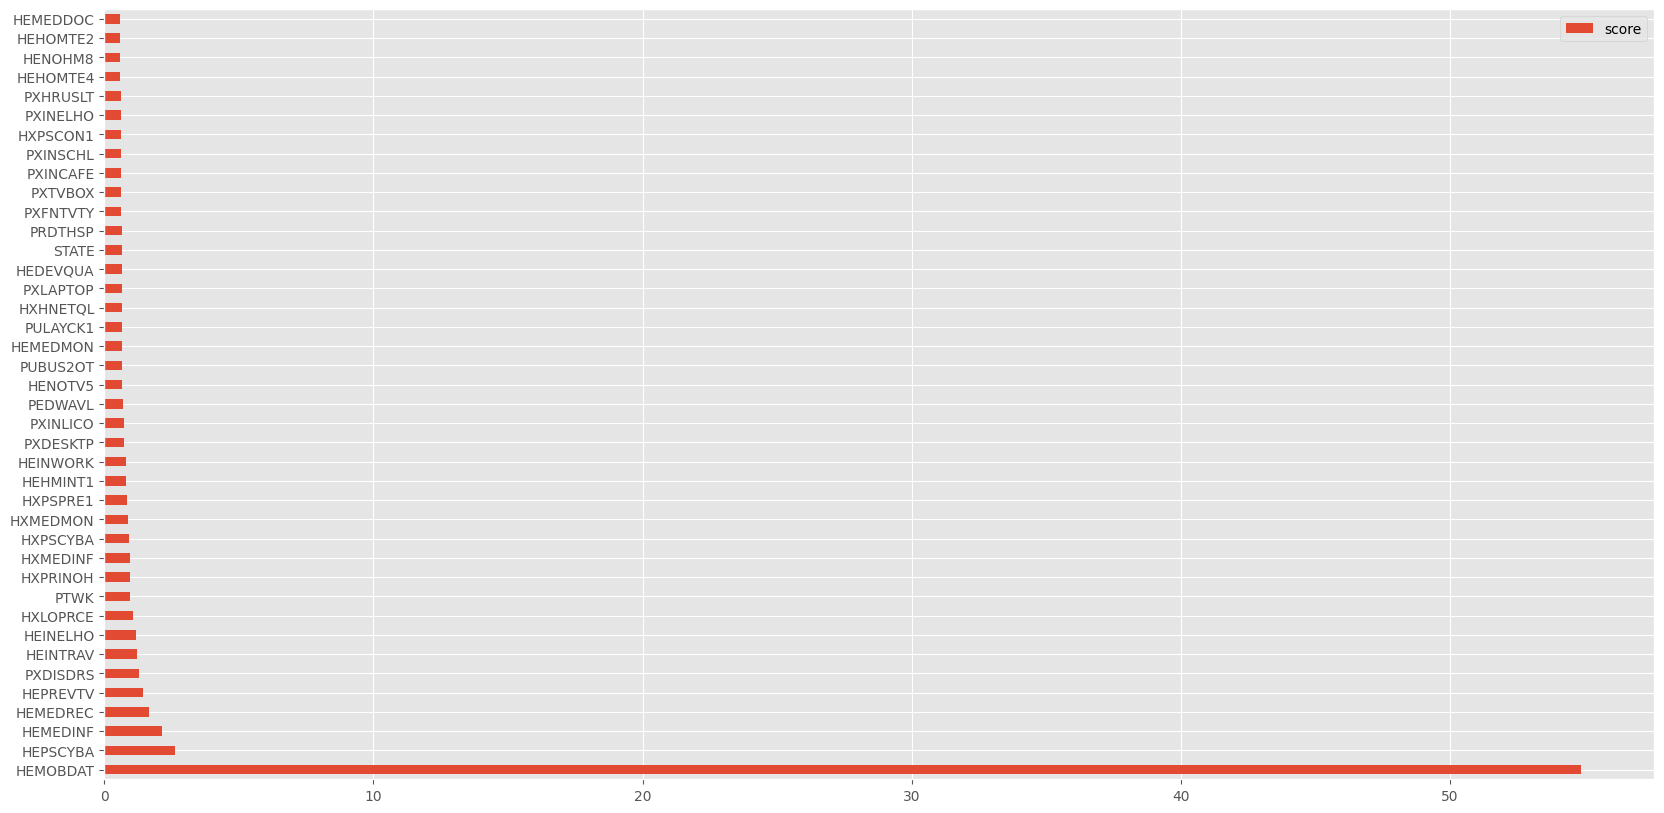

In [121]:
sorted_res = sorted(xgb_bo.res,key = lambda x: x['target'])
params = sorted_res[-1]
params['params']['max_depth'] = int(params['params']['max_depth'])
model = xgb.train(params, xgtrain, num_boost_round=1000)

# Reference: https://stackoverflow.com/questions/37627923/how-to-get-feature-importance-in-xgboost

feature_important = model.get_score(importance_type='gain')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(40, columns="score").plot(kind='barh', figsize = (20,10)) ## plot top 40 features

In [123]:
# Evaluate model on training set
y_pred_train = model.predict(xgtrain)
y_pred_train = np.where(y_pred_train > 0.5, 1, 0)
from sklearn.metrics import accuracy_score
accuracy_score(y_train, y_pred_train)

/Users/gauravniranjan/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/Users/gauravniranjan/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/Users/gauravniranjan/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/Users/gauravniranjan/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/Users/gauravniranjan/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605

0.9988866285462943

In [124]:
# Evaluate model on test set
xgtest = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)
y_pred_test = model.predict(xgtest)
y_pred_test = np.where(y_pred_test > 0.5, 1, 0)
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred_test)

/Users/gauravniranjan/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/Users/gauravniranjan/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/Users/gauravniranjan/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/Users/gauravniranjan/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/Users/gauravniranjan/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605

0.8847105393369619

# Factor Analysis

<Axes: >

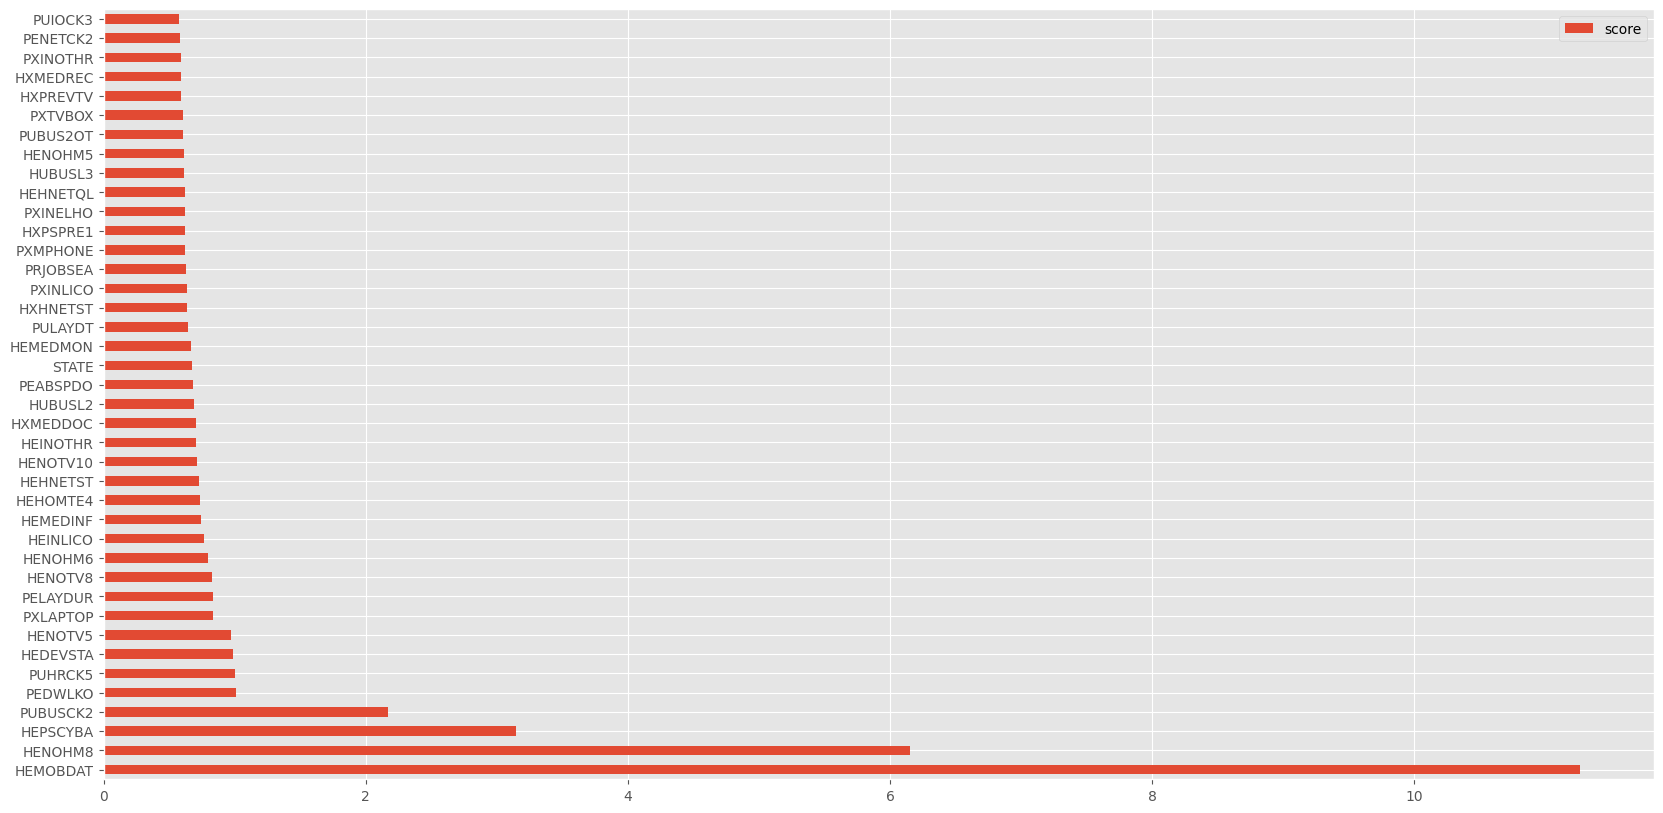

In [60]:
#reduce columns of the dataset

#Using top K important columns from xgboost

# Top 40 columns:
feature_important = model.get_score(importance_type='gain')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(40, columns="score").plot(kind='barh', figsize = (20,10)) ## plot top 40 features


In [61]:
# Top 100 column names
data.nlargest(100, columns='score').index

Index(['HEMOBDAT', 'HENOHM8', 'HEPSCYBA', 'PUBUSCK2', 'PEDWLKO', 'PUHRCK5',
       'HEDEVSTA', 'HENOTV5', 'PXLAPTOP', 'PELAYDUR', 'HENOTV8', 'HENOHM6',
       'HEINLICO', 'HEMEDINF', 'HEHOMTE4', 'HEHNETST', 'HENOTV10', 'HEINOTHR',
       'HXMEDDOC', 'HUBUSL2', 'PEABSPDO', 'STATE', 'HEMEDMON', 'PULAYDT',
       'HXHNETST', 'PXINLICO', 'PRJOBSEA', 'PXMPHONE', 'HXPSPRE1', 'PXINELHO',
       'HEHNETQL', 'HUBUSL3', 'HENOHM5', 'PUBUS2OT', 'PXTVBOX', 'HXPREVTV',
       'HXMEDREC', 'PXINOTHR', 'PENETCK2', 'PUIOCK3', 'HEHOMTE3', 'HEHMINT1',
       'HENOTV11', 'HEDEVQUA', 'GTCBSASZ', 'HETVBOX', 'HEINCAFE', 'PUIO2MFG',
       'HEINTRAV', 'HENOTV4', 'HEINELHO', 'PEDWAVL', 'HXPSCYBA', 'HEWEARAB',
       'PRMARSTA', 'PXINTRAV', 'PXINHOME', 'PUIOCK2', 'HELAPTOP', 'HETABLET',
       'HEINSCHL', 'PUHRCK2', 'HRNUMHOU', 'HXMEDINF', 'PXINCAFE', 'HENOTV7',
       'HEMEDDOC', 'PRWKSCH', 'PXCONFER', 'PRDTCOW2', 'HENOTV12', 'HENOTV2',
       'HEHOMTE1', 'HEHOMTE2', 'HEHOUSUT', 'PRDTHSP', 'HUBUSL1', 'PRUNTYPE'

In [62]:
df_train1.shape

(90941, 424)

In [63]:
df_mca = df_train1[data.nlargest(100, columns='score').index]

In [64]:
df_mca.shape

(90941, 100)

In [65]:
mca = prince.MCA(
    n_components=50,
    n_iter=3,
    copy=False,
    check_input=True,
    random_state=20,
    engine="sklearn",
)
mca = mca.fit(df_mca)

/Users/gauravniranjan/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/gauravniranjan/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/gauravniranjan/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/gauravniranjan/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in 

In [66]:
mca.eigenvalues_summary

,eigenvalue,% of variance,% of variance (cumulative)
component,,,
0,0.284,7.10%,7.10%
1,0.217,5.42%,12.53%
2,0.144,3.60%,16.12%
3,0.087,2.18%,18.31%
4,0.055,1.37%,19.68%
5,0.047,1.18%,20.85%
6,0.040,1.01%,21.86%
7,0.036,0.90%,22.76%
8,0.031,0.77%,23.53%


In [67]:
mca.column_contributions_.style.format('{:.0%}')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
HEMOBDAT_-1,3%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%
HEMOBDAT_1,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,1%,1%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%
HEMOBDAT_2,0%,0%,0%,0%,1%,0%,0%,1%,0%,0%,0%,0%,0%,0%,1%,0%,0%,1%,1%,0%,0%,0%,0%,1%,1%,0%,0%,1%,6%,7%,2%,0%,3%,0%,1%,0%,2%,0%,0%,0%,1%,0%,0%,0%,0%,0%,0%,1%,0%,0%
HENOHM8_-1,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%
HENOHM8_1,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,1%,0%,1%,0%,0%,1%,0%,0%,0%,0%,1%,0%,0%,0%,1%,1%,4%
HENOHM8_2,2%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%
HEPSCYBA_-1,3%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%
HEPSCYBA_1,0%,0%,0%,0%,0%,0%,0%,1%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,1%,0%,0%,0%,0%,0%,0%,0%,0%,0%,1%,0%,0%,0%,0%,0%,1%,0%,0%,0%,0%,0%,0%,0%,0%,0%,1%,0%,0%,0%
HEPSCYBA_2,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%
PUBUSCK2_-1,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%


In [68]:
mca.row_coordinates(df_mca).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
0,-0.188633,0.022043,-0.279406,-0.229783,0.142036,-0.042021,0.009501,-0.148563,-0.002632,0.016776,0.051345,-0.128630,0.036267,-0.112547,-0.162506,-0.085798,-0.121859,0.024008,0.015935,0.080845,0.053570,0.010625,-0.068283,-0.196795,0.090826,0.014936,-0.006481,0.011615,0.114886,0.141734,-0.055586,-0.070401,-0.067571,0.135998,-0.061181,0.045907,-0.003009,-0.078286,-0.194363,-0.004392,0.049681,0.064604,0.078481,0.013852,-0.090395,-0.034073,-0.017564,0.129392,-0.077902,0.013039
1,-0.152140,0.012533,-0.219802,-0.194561,-0.097009,0.174074,-0.005697,-0.319748,0.006285,0.023886,0.048981,-0.078751,-0.014510,0.045592,-0.013871,-0.044648,-0.048887,0.030646,-0.012311,0.031391,0.036603,-0.058805,-0.091156,-0.070307,0.108254,0.045739,-0.017410,0.019592,0.091654,0.148327,-0.056829,-0.079432,-0.026330,0.142458,-0.043228,0.049746,-0.021425,-0.085478,-0.184659,-0.005929,0.052509,0.071491,0.087493,0.023259,-0.064494,-0.045486,-0.020170,0.128657,-0.090108,0.035994
5,-0.227176,0.024101,-0.282621,-0.201041,-0.081336,-0.363712,0.106095,-0.164790,0.042456,0.026004,0.051817,-0.124812,-0.013056,0.130819,-0.001918,-0.038134,-0.022019,-0.023317,0.044213,0.022490,0.198755,-0.017382,0.048271,0.015978,-0.055433,0.129823,-0.019208,-0.045925,0.066051,0.096278,0.045263,-0.022777,-0.032527,-0.013683,-0.034046,0.043790,-0.073873,-0.046994,-0.121565,-0.018096,-0.006803,0.014407,0.116996,0.028814,-0.091066,-0.042593,-0.000959,0.078891,-0.095771,0.068620
6,-0.149805,0.000470,0.690299,0.331850,0.109598,0.248699,-0.082629,0.043835,-0.155650,-0.072416,-0.067148,0.017144,-0.004037,-0.138084,0.146879,-0.041593,-0.016326,-0.031655,0.024634,0.021351,-0.016409,0.081494,0.056970,-0.231005,0.067551,-0.055100,-0.049230,-0.127223,0.014847,0.048671,-0.162749,0.066205,-0.043584,0.060602,-0.022585,0.061662,-0.002781,-0.182299,-0.192817,-0.145521,0.014117,0.010850,0.102000,0.103186,-0.143676,0.051717,0.061674,-0.074521,-0.042112,0.050080
7,-0.216013,0.005902,0.830497,0.349175,-0.074478,-0.135362,0.018658,0.068401,-0.183903,-0.036748,-0.026800,-0.036568,-0.024871,-0.167729,0.026247,-0.047405,-0.100749,-0.061805,0.079309,0.089569,-0.123320,0.069290,-0.135983,-0.017866,0.163167,-0.155650,-0.137390,-0.117052,0.035180,0.099241,-0.161079,0.005301,0.012152,0.115472,-0.037726,0.067661,-0.022990,-0.170398,-0.169095,-0.162699,0.004202,0.046949,0.094493,0.107421,-0.123385,0.058323,0.076702,-0.103864,-0.034765,0.054713


In [69]:
mca.column_coordinates(df_mca).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
HEMOBDAT_-1,2.435142,-0.455655,-0.072429,0.006346,-0.204071,0.035127,-0.049373,0.228096,-0.058344,-0.017879,-0.015338,0.007881,-0.017518,-0.063469,0.032690,-0.023710,-0.061874,0.036391,-0.072299,-0.030721,0.013330,-0.005596,0.131274,0.054072,0.007317,0.050532,-0.052194,-0.092478,0.105632,0.062495,0.036243,-0.084618,-0.018201,-0.037984,0.020917,-0.033788,0.035511,-0.008508,0.018679,-0.021069,-0.031597,0.043833,0.011968,0.028254,-0.062121,0.022267,0.027291,-0.036172,0.042759,0.026354
HEMOBDAT_1,-0.394605,0.078427,0.009502,0.022660,-0.042907,0.043123,-0.007066,0.047802,-0.014180,0.008751,0.002782,-0.003583,-0.005047,0.008544,-0.053954,-0.010063,-0.025668,0.043048,-0.048766,0.000719,-0.006966,-0.036809,0.000812,0.049792,0.046128,-0.020825,0.004163,-0.032660,0.101000,0.117260,0.062860,-0.018693,-0.082949,0.001916,-0.061573,0.003950,0.059019,-0.030912,-0.008001,0.027158,-0.043456,-0.032833,-0.019963,0.000264,0.008185,-0.010430,0.011572,0.049492,0.011490,-0.016148
HEMOBDAT_2,-0.198720,0.004543,0.021807,-0.168975,0.556956,-0.350016,0.111179,-0.621413,0.172834,-0.040173,-0.000860,0.015753,0.057511,0.017561,0.343352,0.100818,0.258888,-0.351042,0.436017,0.032799,0.033093,0.268676,-0.167767,-0.420823,-0.337071,0.085742,0.034801,0.346382,-0.848613,-0.911010,-0.491750,0.237354,0.612349,0.033249,0.412063,0.013600,-0.463536,0.230328,0.033851,-0.167137,0.348028,0.179402,0.127198,-0.036745,0.018448,0.046697,-0.115975,-0.307325,-0.134473,0.082313
HENOHM8_-1,-0.395633,0.124510,-0.000228,-0.002653,0.023994,0.014465,-0.019522,-0.030384,0.001627,-0.002433,0.001095,-0.005041,0.006009,-0.030123,0.039074,-0.001983,-0.004343,-0.003651,-0.008661,-0.007961,-0.005626,-0.002148,0.023103,0.019371,-0.000956,0.015146,-0.001927,-0.005372,0.009767,0.004266,0.006061,-0.000805,-0.011128,-0.008758,0.000436,0.006569,0.002219,0.000052,0.001561,-0.007181,0.004252,0.006745,0.008185,-0.001035,-0.011436,0.007652,-0.000789,-0.006957,0.001040,0.002699
HENOHM8_1,2.045185,-0.653683,0.020412,-0.268260,-0.343541,-0.050629,0.125283,0.087909,-0.079844,0.159312,0.021723,-0.351579,0.485125,-0.390099,-0.416750,-0.015860,0.039687,0.235619,0.213638,0.365261,-0.256080,0.259664,0.199661,-0.397161,0.016918,-0.216851,0.811331,0.074280,-1.317305,0.392292,-0.013031,0.293092,-0.144066,1.710674,-0.537880,1.663237,0.101584,-0.338067,-1.660713,-0.997772,-0.720176,-0.622492,-0.816913,-1.848280,-0.975624,-0.730850,-0.065625,1.887676,1.343649,3.352341
